#Traffic Lights Detection

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

/home/eddie/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/eddie/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/eddie/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/eddie/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/eddie/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary

# MobileNets
MobileNets, as the name suggests, are neural networks constructed for the purpose of running very efficiently (high FPS, low memory footprint) on mobile and embedded devices. MobileNets achieve this with 3 techniques:

Perform a depthwise convolution followed by a 1x1 convolution rather than a standard convolution. The 1x1 convolution is called a pointwise convolution if it's following a depthwise convolution. The combination of a depthwise convolution followed by a pointwise convolution is sometimes called a separable depthwise convolution.
Use a "width multiplier" - reduces the size of the input/output channels, set to a value between 0 and 1.
Use a "resolution multiplier" - reduces the size of the original input, set to a value between 0 and 1.
These 3 techiniques reduce the size of cummulative parameters and therefore the computation required. Of course, generally models with more paramters achieve a higher accuracy. MobileNets are no silver bullet, while they perform very well larger models will outperform them. MobileNets are designed for mobile devices, NOT cloud GPUs. The reason we're using them in this lab is automotive hardware is closer to mobile or embedded devices than beefy cloud GPUs.

Convolutions
Vanilla Convolution
Before we get into the MobileNet convolution block let's take a step back and recall the computational cost of a vanilla convolution. There are $N$ kernels of size $D_k * D_k$. Each of these kernels goes over the entire input which is a $D_f * D_f * M$ sized feature map or tensor (if that makes more sense). The computational cost is:

$$
D_f * D_f * M * N * D_k * D_k
$$
Let $D_g * D_g$ be the size of the output feature map. Then a standard convolution takes in a $D_f * D_f * M$ input feature map and returns a $D_g * D_g * N$ feature map as output.

Standard Convolution

Depthwise Convolution
A depthwise convolution acts on each input channel separately with a different kernel. $M$ input channels implies there are $M$ $D_k * D_k$ kernels. Also notice this results in $N$ being set to 1. If this doesn't make sense, think about the shape a kernel would have to be to act upon an inidividual channel.

Computation cost:

$$
D_f * D_f * M * D_k * D_k
$$
Depthwise Convolution

Pointwise Convolution
A pointwise convolution performs a 1x1 convolution, it's the same as a vanilla convolution except the kernel size is $1 * 1$.

Computation cost:

$$
D_k * D_k * D_f * D_f * M * N =
1 * 1 * D_f * D_f * M * N =
D_f * D_f * M * N
$$
Pointwise Convolution

Thus the total computation cost is for separable depthwise convolution:

$$
D_f * D_f * M * D_k * D_k + D_f * D_f * M * N
$$
which results in $\frac{1}{N} + \frac{1}{D_k^2}$ reduction in computation:

$$
\frac {D_f * D_f * M * D_k * D_k + D_f * D_f * M * N} {D_f * D_f * M * N * D_k * D_k} = 
\frac {D_k^2 + N} {D_k^2*N} = 
\frac {1}{N} + \frac{1}{D_k^2}
$$
MobileNets use a 3x3 kernel, so assuming a large enough $N$, separable depthwise convnets are ~9x more computationally efficient than vanilla convolutions!

Width Multiplier
The 2nd technique for reducing the computational cost is the "width multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\alpha$. $\alpha$ reduces the number of input and output channels proportionally:

$$
D_f * D_f * \alpha M * D_k * D_k + D_f * D_f * \alpha M * \alpha N
$$
Resolution Multiplier
The 3rd technique for reducing the computational cost is the "resolution multiplier" which is a hyperparameter inhabiting the range [0, 1] denoted here as $\rho$. $\rho$ reduces the size of the input feature map:

$$
\rho D_f * \rho D_f * M * D_k * D_k + \rho D_f * \rho D_f * M * N
$$
Combining the width and resolution multipliers results in a computational cost of:

$$
\rho D_f * \rho D_f * a M * D_k * D_k + \rho D_f * \rho D_f * a M * a N
$$
Training MobileNets with different values of $\alpha$ and $\rho$ will result in different speed vs. accuracy tradeoffs. The folks at Google have run these experiments, the result are shown in the graphic below:

MobileNets Graphic

MACs (M) represents the number of multiplication-add operations in the millions.

Exercise 1 - Implement Separable Depthwise Convolution
In this exercise you'll implement a separable depthwise convolution block and compare the number of parameters to a standard convolution block. For this exercise we'll assume the width and resolution multipliers are set to 1.

Docs:

## Implementing Separable Depthwise Convolution

In [2]:
def vanilla_conv_block(x, kernel_size, output_channels):
    """
    Vanilla Conv -> Batch Norm -> ReLU
    """
    x = tf.layers.conv2d(
        x, output_channels, kernel_size, (2, 2), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

# TODO: implement MobileNet conv block
def mobilenet_conv_block(x, kernel_size, output_channels):
    """
    Depthwise Conv -> Batch Norm -> ReLU -> Pointwise Conv -> Batch Norm -> ReLU
    """
    print("****** {}".format(x.shape.as_list()[-1]))
    print("****** kernel {}".format(int(kernel_size)))
    shape = x.shape.as_list()
    # Depthwise block
    f = tf.random_normal([int(kernel_size), int(kernel_size), int(shape[-1]), 1])
    dx = tf.nn.depthwise_conv2d(x, f, [1, 1, 1, 1], "SAME", data_format="NHWC")
    dx = tf.layers.batch_normalization(dx)
    dx = tf.nn.relu(dx)
    
    # Pointwise block
    dx = tf.layers.conv2d(dx, output_channels, 1, 1)
    dx = tf.layers.batch_normalization(dx)
    dx = tf.nn.relu(dx)
    
    return dx

## Building the Neural Network

In [3]:
# constants but you can change them so I guess they're not so constant :)
INPUT_CHANNELS = 32
OUTPUT_CHANNELS = 512
KERNEL_SIZE = 3
IMG_HEIGHT = 256
IMG_WIDTH = 256

with tf.Session(graph=tf.Graph()) as sess:
    # input
    x = tf.constant(np.random.randn(1, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), dtype=tf.float32)

    with tf.variable_scope('vanilla'):
        vanilla_conv = vanilla_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
    with tf.variable_scope('mobile'):
        mobilenet_conv = mobilenet_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)

    vanilla_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla')
    ]
    mobile_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'mobile')
    ]

    print("VANILLA CONV BLOCK")
    total_vanilla_params = sum([p[1] for p in vanilla_params])
    for p in vanilla_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_vanilla_params)
    print()

    print("MOBILENET CONV BLOCK")
    total_mobile_params = sum([p[1] for p in mobile_params])
    for p in mobile_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_mobile_params)
    print()

    print("{0:.3f}x parameter reduction".format(total_vanilla_params /
                                             total_mobile_params))

****** 32
****** kernel 3
VANILLA CONV BLOCK
Variable vanilla/conv2d/kernel:0: number of params = 147456
Variable vanilla/conv2d/bias:0: number of params = 512
Variable vanilla/batch_normalization/beta:0: number of params = 512
Variable vanilla/batch_normalization/gamma:0: number of params = 512
('Total number of params =', 148992)
()
MOBILENET CONV BLOCK
Variable mobile/batch_normalization/beta:0: number of params = 32
Variable mobile/batch_normalization/gamma:0: number of params = 32
Variable mobile/conv2d/kernel:0: number of params = 16384
Variable mobile/conv2d/bias:0: number of params = 512
Variable mobile/batch_normalization_1/beta:0: number of params = 512
Variable mobile/batch_normalization_1/gamma:0: number of params = 512
('Total number of params =', 17984)
()
8.000x parameter reduction


### MobileNet SSD

In this section you'll use a pretrained MobileNet SSD model to perform object detection. You can download the MobileNet SSD and other models from the TensorFlow detection model zoo. Paper describing comparing several object detection models.

Alright, let's get into SSD!



## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the pretrained models from the model zoo.

In [47]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'models/frozen_graphs/real_mobilenets_ssd_38k_epochs_frozen_inference_graph.pb'
#SSD_GRAPH_FILE = 'models/frozen_graphs/sim_mobilenets_ssd_30k_epochs_frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'

The auxiliary functions below are important to display the bounding boxes

In [48]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

('Number of colors =', 147)


Let's set up important variables before we start

In [49]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Let's test on an example

[0.95173484] [2.]


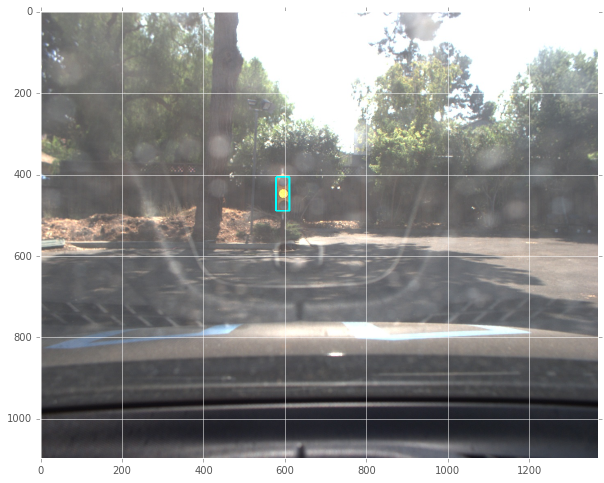

In [50]:
# Load a sample image.
#image = Image.open('./assets/sample1.jpg')
image = Image.open('./assets/real_yellow_traffic_light.jpg')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    print scores, classes

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)

In [51]:
def detection_pipeline(img_path, min_conf=0.8):
    image = Image.open(img_path)
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    print(image_np.shape)

    with tf.Session(graph=detection_graph) as sess:                
        # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = min_conf
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
        print scores, classes

        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)

        # Each class with be represented by a differently colored box
        draw_boxes(image, box_coords, classes)

        plt.figure(figsize=(12, 8))
        plt.imshow(image)

(1, 1096, 1368, 3)
[0.9916186] [1.]


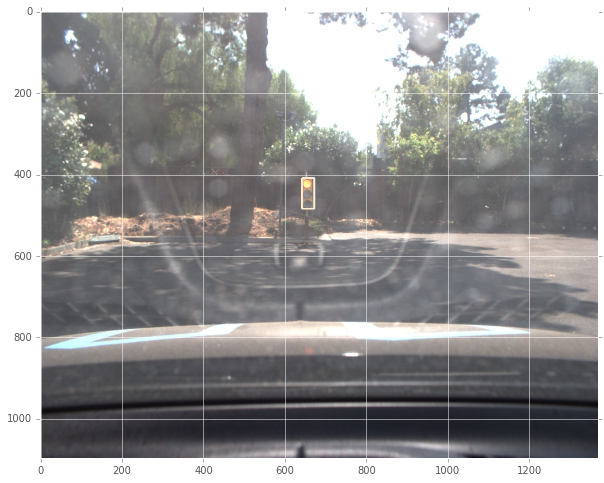

In [52]:
detection_pipeline('./assets/real_red_traffic_light.jpg')

(1, 1096, 1368, 3)
[0.98823315] [3.]


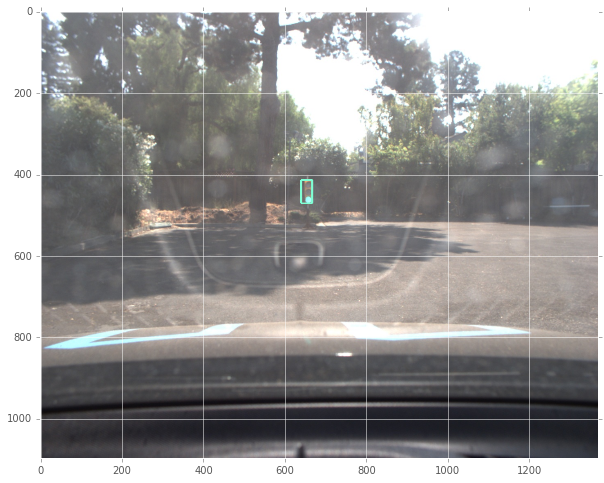

In [53]:
detection_pipeline('./assets/real_green_traffic_light.jpg')

(1, 1096, 1368, 3)
[] []


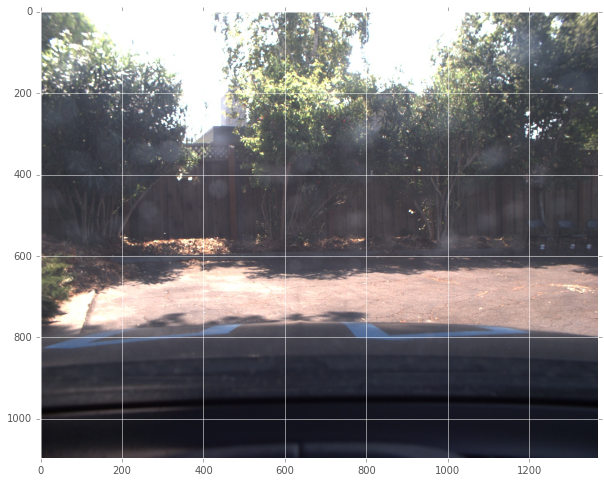

In [54]:
detection_pipeline('./assets/real_no_traffic_light.jpg')

(1, 1096, 1368, 3)
[] []


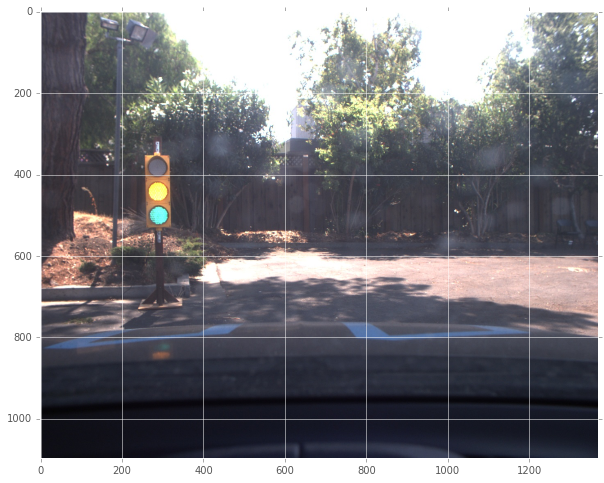

In [55]:
detection_pipeline('./assets/real_unidentified_traffic_light.jpg')

(1, 600, 800, 3)
[] []


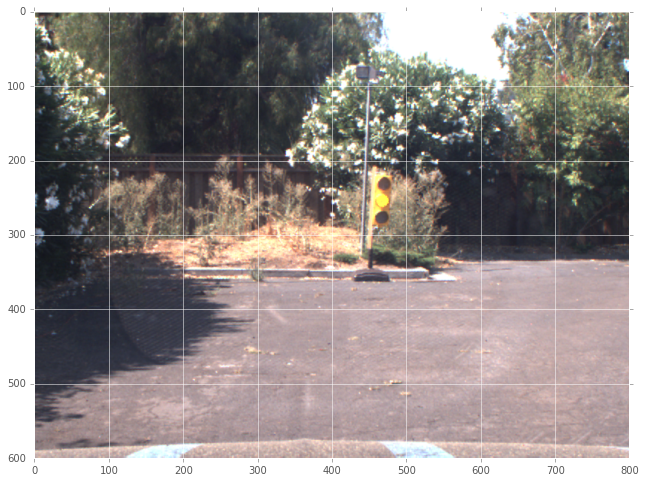

In [57]:
detection_pipeline('./assets/test_real.png', min_conf=0.1)